Sử dụng mô hình Học máy để phục vụ dự báo cổ phiếu. Ở phần này sử dụng cổ phiếu FPT trong lĩnh vực công nghệ, dữ liệu sử dụng để train sẽ là trước năm 2024 và phần test sẽ là sau năm 2024 để có thể đánh giá tốt nhất.

In [1]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession



spark = SparkSession.builder \
    .appName("Stock_price_predict") \
    .master("spark://spark-master:7077") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://namenode:9000") \
    .getOrCreate()


In [2]:
df = spark.read.csv("hdfs://namenode:9000/data/FPT.csv", header=True, inferSchema=True)
df.show()

+----------+----+----+----+-----+------+
|      time|open|high| low|close|volume|
+----------+----+----+----+-----+------+
|2015-01-05|7.34|7.37|7.28| 7.31|273550|
|2015-01-06|7.27|7.36|7.24| 7.36|364050|
|2015-01-07|7.36|7.51|7.36|  7.4|405560|
|2015-01-08|7.39| 7.4|7.31| 7.33|227300|
|2015-01-09|7.33|7.42|7.33| 7.39|320210|
|2015-01-12|7.39|7.53|7.39| 7.43|679050|
|2015-01-13| 7.4|7.47| 7.4| 7.45|242060|
|2015-01-14|7.45|7.48|7.37| 7.43|421120|
|2015-01-15|7.47|7.47| 7.4| 7.45|281910|
|2015-01-16|7.47|7.47| 7.4| 7.42|174340|
|2015-01-19|7.42|7.42|7.34| 7.34|367020|
|2015-01-20|7.34|7.37|7.33| 7.34|344010|
|2015-01-21|7.37|7.47|7.37|  7.4|607260|
|2015-01-22|7.43|7.43|7.37| 7.37|299200|
|2015-01-23| 7.4|7.45|7.37|  7.4|386280|
|2015-01-26| 7.4|7.45| 7.4|  7.4|384170|
|2015-01-27|7.39|7.43|7.34| 7.34|424160|
|2015-01-28|7.33|7.39|7.31| 7.33|260670|
|2015-01-29|7.33|7.34|7.31| 7.33|224460|
|2015-01-30|7.34|7.36|7.27| 7.27|587470|
+----------+----+----+----+-----+------+
only showing top

In [3]:
from pyspark.sql.functions import expr, col, column
df = df.withColumn("Mean", expr('(high+low)/2')) # thêm cột Mean 

In [4]:
df.show(5)

+----------+----+----+----+-----+------+------------------+
|      time|open|high| low|close|volume|              Mean|
+----------+----+----+----+-----+------+------------------+
|2015-01-05|7.34|7.37|7.28| 7.31|273550|             7.325|
|2015-01-06|7.27|7.36|7.24| 7.36|364050| 7.300000000000001|
|2015-01-07|7.36|7.51|7.36|  7.4|405560|7.4350000000000005|
|2015-01-08|7.39| 7.4|7.31| 7.33|227300|             7.355|
|2015-01-09|7.33|7.42|7.33| 7.39|320210|             7.375|
+----------+----+----+----+-----+------+------------------+
only showing top 5 rows



Để dự đoán cổ phiếu, ta sử dụng mạng LSTM vì giá cổ phiếu còn phụ thuộc vào những đặc trưng thời gian, LSTM học được phụ thuộc dài hạn, phi tuyến giúp mô hình học được xu hướng và chu kỳ trong giá cổ phiếu. Giờ đây ta sử dụng để dự đoán giá cổ phiếu của FPT. Chiến thuật 60 ngày dự đoán 1 ngày, số lượng train là 2000 ngày còn test trên 499 ngày (sau năm 2023)

In [9]:
data = df.toPandas()

In [11]:
data.head()

,time,open,high,low,close,volume,Mean
0,2015-01-05,7.34,7.37,7.28,7.31,273550,7.325
1,2015-01-06,7.27,7.36,7.24,7.36,364050,7.300
2,2015-01-07,7.36,7.51,7.36,7.40,405560,7.435
3,2015-01-08,7.39,7.40,7.31,7.33,227300,7.355
4,2015-01-09,7.33,7.42,7.33,7.39,320210,7.375


In [7]:
pip install torch --no-cache-dir


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.8/899.8 MB 14.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 16.3 MB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 14.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 14.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 13.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 22.1 MB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 22.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 15.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 24.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 26.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [12]:
data = data['Mean'].values.reshape(-1, 1)

In [ ]:

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
# xu ly du lieu de su dung 60 ngay du doan 1 ngay
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 60  
X, y = create_sequences(scaled_data, seq_length)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [14]:
# Tạo dataset cho DataLoader
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# DataLoader
batch_size = 32
train_dataset = StockDataset(X_train, y_train)
test_dataset = StockDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
# Xây dựng mô hình LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.linear(out[:, -1, :])
        return out

model = LSTMModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
# Training 
epochs = 100  
for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.0000
Epoch [20/100], Loss: 0.0000
Epoch [30/100], Loss: 0.0000
Epoch [40/100], Loss: 0.0000
Epoch [50/100], Loss: 0.0000
Epoch [60/100], Loss: 0.0000
Epoch [70/100], Loss: 0.0001
Epoch [80/100], Loss: 0.0000
Epoch [90/100], Loss: 0.0000
Epoch [100/100], Loss: 0.0000


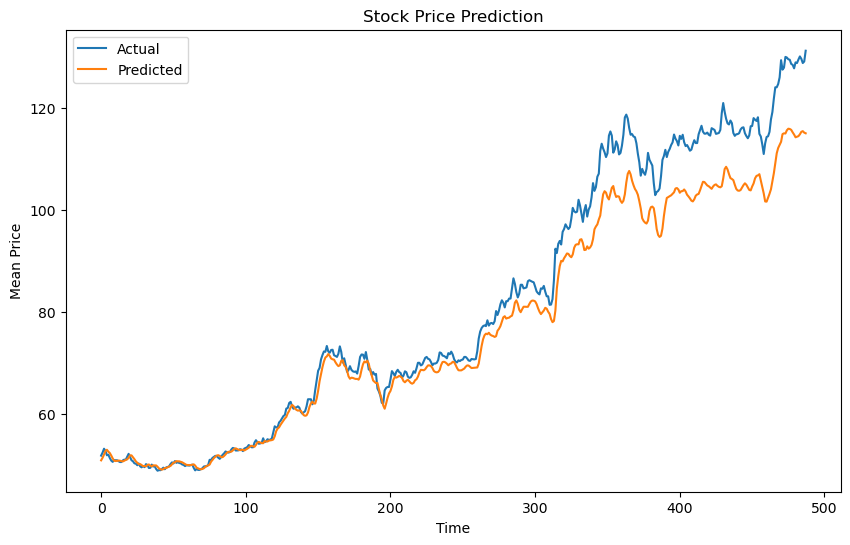

In [18]:
import matplotlib.pyplot as plt
# Evaluation
model.eval()
with torch.no_grad():
    predictions = []
    for X_batch, _ in test_loader:
        output = model(X_batch)
        predictions.append(output.numpy())

predictions = np.concatenate(predictions)
predictions = scaler.inverse_transform(predictions)

# Vì ta scale dữ liệu ban đầu nên ta cần inverse lại để rõ kêt quả
y_test_inv = scaler.inverse_transform(y_test.numpy())

plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Mean Price')
plt.legend()
plt.show()

In [19]:
spark.stop()